In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import imdb
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics


In [2]:
print(tf.__version__)

1.12.0


- Load the IMDB dataset

In [3]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

 - Data analysis

In [4]:
print("Training entries: {}, - Data analysis labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, - Data analysis labels: 25000


In [5]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
len(train_data[0]), len(train_data[1])

(218, 189)

In [7]:
# Decode one review
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2 # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [8]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

- Preparing the data

Pad the arrays so they all have the same length, then create an integer tensor of shape max_length * num_reviews. We can use an embedding layer capable of handling this shape as the first layer in our network.

In [9]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data,
                                                          value=word_index["<PAD>"],
                                                          padding='post',
                                                          maxlen=256)
test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data,
                                                          value=word_index["<PAD>"],
                                                          padding='post',
                                                          maxlen=256)

In [10]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [11]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

- Build the model

In [12]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = models.Sequential()
model.add(layers.Embedding(vocab_size, 16))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(16, activation=tf.nn.relu))
model.add(layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()
tensorboard = TensorBoard(log_dir='/notebooks/99.logs')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


- Model compilation

In [13]:
model.compile(optimizer=optimizers.Adam(),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

- Create a validation set

In [14]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]
y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

- Train the model

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 41us/step - loss: 0.6919 - binary_accuracy: 0.6055 - val_loss: 0.6900 - val_binary_accuracy: 0.7143
Epoch 2/40
15000/15000 [==============================] - 0s 33us/step - loss: 0.6864 - binary_accuracy: 0.7437 - val_loss: 0.6822 - val_binary_accuracy: 0.7451
Epoch 3/40
15000/15000 [==============================] - 1s 33us/step - loss: 0.6746 - binary_accuracy: 0.7629 - val_loss: 0.6677 - val_binary_accuracy: 0.7538
Epoch 4/40
15000/15000 [==============================] - 0s 33us/step - loss: 0.6540 - binary_accuracy: 0.7651 - val_loss: 0.6445 - val_binary_accuracy: 0.7589
Epoch 5/40
15000/15000 [==============================] - 0s 33us/step - loss: 0.6221 - binary_accuracy: 0.7877 - val_loss: 0.6091 - val_binary_accuracy: 0.7809
Epoch 6/40
15000/15000 [==============================] - 0s 33us/step - loss: 0.5803 - binary_accuracy: 0.8067 - val_loss: 0.5685 - val_binary_a

In [16]:
result = model.evaluate(test_data, test_labels)
print(model.metrics_names)
print(result)

25000/25000 [==============================] - 0s 19us/step
['loss', 'binary_accuracy']
[0.3236307553386688, 0.87312]


- Training logs

In [17]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


- Create a graph of accuracy and loss over time

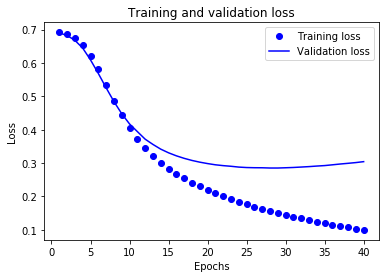

In [18]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['binary_accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

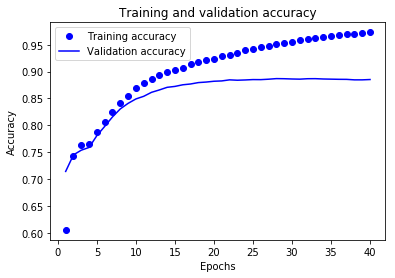

In [19]:
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- Generate predictions on new data

In [20]:
# test against random words and biased review
rand_review = np.random.randint(10000, size=256)
biased_review = np.full(256, 530)
test_data = np.append(test_data, [rand_review], axis=0)
test_data = np.append(test_data, [biased_review], axis=0)
predict = model.predict(test_data)

In [21]:
print('Random words:', decode_review(test_data[-2]))

Random words: comments plant hollywood arrest cinema little jumping examples ajay name thought local argue wanting opportunities instinct ny politics wilderness audiences conquest talentless anything brides prove kaufman apartheid star martian dancer appeal scariest walter troubles mccoy allegory parts gus louise cheerful delicious core details thirties loses oppressive mirrors rochester ghost poetry frankie desert excitement results meet jessie neglected phenomenon hiding stealth gentlemen 700 follows tasks submit jedi documentaries correctly carradine gender assured sketch antonioni difference successful hiring mormon redeeming adventurous sketches heist waving jail bulk slept deputy returning intestines attack administration removed ostensibly slaves masterson chose cody peculiar superstar directorial track ear harold apparently anne 200 incorrect fades tries spoof visits trusted advice realm cheap snl disliked perspective bow idiot coop egypt controlled virtues psychotic notion gra

In [22]:
print('Prediction:', predict[-2])

Prediction: [0.74312097]


In [23]:
print('Biased review:', decode_review(test_data[-1]))

Biased review: brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brilliant brill

In [24]:
print('Prediction:', predict[-1])

Prediction: [1.]
